# Многорукие бандиты

- Множество состояний $\mathcal{S}$ состоит из одного элемента: $|\mathcal{S}| = 1$, поэтому проблема credit assignment в данном случае не стоит.
- Множество действий $\mathcal{A} = \{1, 2, \ldots, M\}$ фиксированно.
- Каждое состояние характеризуется *ожидаемой наградой:*
$$q(a) := \mathbb{E}[R_t | A_t = a], a \in A, t \in \mathbb{N}$$
При этом считаем, что распределение наград не меняется во времени.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt

Зададим генератор seed-ов для воспроизводимости кода.

In [2]:
def seed_gen(seed=2025):
    rng = np.random.default_rng(2025)
    while True:
        yield rng.integers(2 ** 32)

seeds = seed_gen()
seeds, next(seeds)

(<generator object seed_gen at 0x7e1e34054d40>, np.int64(1921882075))

Класс `bandit.MultiArmedBandit` позволяет моделировать многоруких бандитов.

In [3]:
from bandits.bandit import MultiArmedBandit


bernoulli_bandit = MultiArmedBandit(distribution="bernoulli", params=[0.9, 0.6], seed=next(seeds))
print(bernoulli_bandit)

MultiArmedBandit(
    Bernoulli(p=0.9),
    Bernoulli(p=0.6)
)


In [4]:
actions = [0, 1, 0, 0, 1]
rewards = [bernoulli_bandit.pull(a) for a in actions]
rewards

[0, 1, 1, 1, 1]

Можно определять бандитов с распределениями наград из различных семейств. Именование параметров соответствует `scipy.stats`

In [5]:
mixed_bandit = MultiArmedBandit(
    [
        ("bernoulli", {"p": 0.5}),
        ("binomial", {"n": 10, "p": 0.1}),
        ("norm", {"loc": 0.5, "scale": 1.0}),
        ("uniform", {}),
    ],
    seed=next(seeds)
)

print(mixed_bandit)

MultiArmedBandit(
    Bernoulli(p=0.5),
    Binomial(n=10, p=0.1),
    Norm(loc=0.5, scale=1.0),
    Uniform()
)


In [6]:
actions = [0, 1, 2, 3]
rewards = [mixed_bandit.pull(a) for a in actions]
rewards

[0, 2, np.float64(2.748717420843048), np.float64(0.17269600218015468)]

Визуализируем распределения наград для двух простых бандитов.

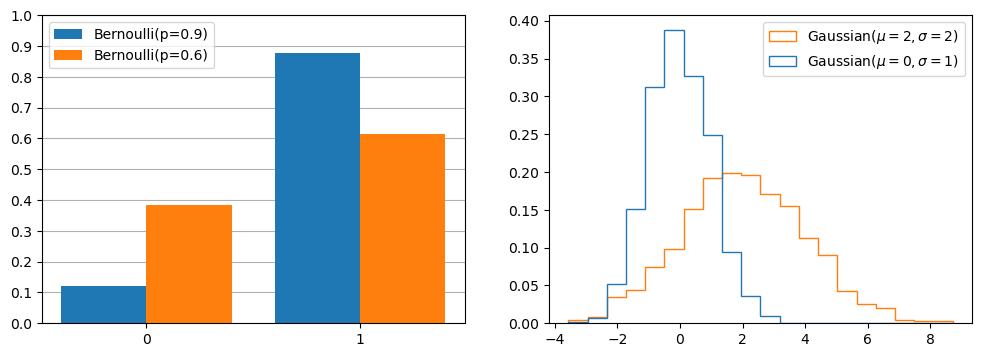

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

bernoulli_bandit = MultiArmedBandit(distribution="bernoulli", params=[0.9, 0.6], seed=next(seeds))
gaussian_bandit = MultiArmedBandit(distribution="gaussian", params=[[0, 1], [2, 2]], seed=next(seeds))

axs[0].hist(
    [[bernoulli_bandit.pull(0) for _ in range(1000)],
     [bernoulli_bandit.pull(1) for _ in range(1000)]],
    bins=[-0.5, 0.5, 1.5],
    density=True,
    label=["Bernoulli(p=0.9)", "Bernoulli(p=0.6)"],
)
axs[0].set_xticks([0, 1])
axs[0].set_ylim(0, 1)
axs[0].set_yticks(np.arange(0.0, 1.1, 0.1))
axs[0].set_axisbelow(True)
axs[0].grid(axis='y')
axs[1].hist(
    [[gaussian_bandit.pull(0) for _ in range(1000)],
     [gaussian_bandit.pull(1) for _ in range(1000)]],
    histtype='step',
    bins=20,
    density=True,
    label=[r"Gaussian($\mu=0, \sigma=1$)", r"Gaussian($\mu=2, \sigma=2$)"]
)
axs[0].legend()
axs[1].legend()
plt.show()

## Жадные стратегии

Жадные стратегии начинают игру с небольшого исследования, дёргая каждую ручку несколько раз (параметр `exploring_cycles`) и накапливая статистику о наградах. После этого абсолютно жадная стратегия дёргает только ручки с наибольшей оценкой награды, продолжая обновлять статистику.

In [8]:
mab = MultiArmedBandit(distribution="bernoulli", params=[0.6, 0.9], seed=next(seeds))
print(mab)

MultiArmedBandit(
    Bernoulli(p=0.6),
    Bernoulli(p=0.9)
)


In [9]:
from bandits.agent import Greedy
from bandits.manager import BanditsManager


manager = BanditsManager(
    environment=mab,
    agent=Greedy(2, exploring_cycles=2),
    n_rounds=20
)
results = manager.run()
results

{'agent_actions': array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'rewards': array([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 'optimal_actions': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'optimal_rewards': array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
        0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])}

In [10]:
results["rewards"].sum()

np.float64(16.0)

In [11]:
manager.agent.value_estimates

array([0.83333333, 0.5       ])

Серьёзный недостаток жадной стратегии в том, что при неудачном выпадении наград на этапе исследований, она рискует незаметить наиболее удачную ручку, и поэтому рискует всегда дёргать субоптимальные ручки.

Улучшением является $\varepsilon$-жадная стратегия. Её отличие в том, что на каждом шаге с вероятностью $\varepsilon$ стратегия будет делать исследование — дёргать за случайную ручку, а с вероятностью $(1 - \varepsilon)$ — использовать накопленные знания и дёргать за ручку с наибольшей оценкой ожидаемой награды, как это всегда делает жадная стратегия.

In [12]:
from bandits.agent import EpsilonGreedy


# В данном случае сравним успехи стратегий при абсолютно идентичном многоруком бандите
mab.reset(seed=mab.seed)

manager = BanditsManager(
    environment=mab,
    agent=EpsilonGreedy(2, epsilon=0.5, seed=next(seeds)),
    n_rounds=20
)
results = manager.run()
results

{'agent_actions': array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]),
 'rewards': array([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 'optimal_actions': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'optimal_rewards': array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
        0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])}

In [13]:
results["rewards"].sum()

np.float64(16.0)

In [14]:
manager.agent.value_estimates

array([0.88888889, 0.72727273])

Полностью случайную стратегию можно считать частным случаем $\varepsilon$-жадной ($\varepsilon = 1$).

In [15]:
from bandits.agent import Random


mab.reset(seed=mab.seed)

manager = BanditsManager(
    environment=mab,
    agent=Random(2, seed=next(seeds)),
    n_rounds=20
)
results = manager.run()
results

{'agent_actions': array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0]),
 'rewards': array([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.]),
 'optimal_actions': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'optimal_rewards': array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
        0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])}

In [16]:
results["rewards"].sum()

np.float64(16.0)

In [17]:
manager.agent.value_estimates

array([0.63636364, 1.        ])

В данном примере так совпало, что все три стратегии получили одну и ту же суммарную награду, но их оценки ожидаемых выигрышей отличаются.

### Сравнение $\varepsilon$-жадных стратегий

По отдельным играм трудно сказать, какая стратегия лучше, поэтому посмотрим на эффективность стратегий в среднем, при большом числе игр.

In [18]:
from bandits.manager import get_average_performance


res = get_average_performance(
    MultiArmedBandit(distribution="gaussian", params=[0.9, 0.6]),
    Greedy(2),
    n_rounds=2000,
    n_runs=100,
    threads=10,
)
res

{'average_rewards': array([1.03408422, 0.65262663, 0.87423443, ..., 0.73886732, 0.69613678,
        0.69660409], shape=(2000,)),
 'optimal_actions_rate': array([1.  , 0.  , 0.61, ..., 0.65, 0.65, 0.65], shape=(2000,)),
 'average_optimal_rewards': array([0.9, 0.9, 0.9, ..., 0.9, 0.9, 0.9], shape=(2000,)),
 'cumulative_regret': array([-1.34084221e-01,  1.13289149e-01,  1.39054722e-01, ...,
         2.07841732e+02,  2.08045596e+02,  2.08248992e+02], shape=(2000,))}

In [19]:
import matplotlib.ticker as mtick


def plot_performance_results(episodes_stats, labels):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    average_optimal_rewards = episodes_stats[0]["average_optimal_rewards"]

    for stats, label in zip(episodes_stats, labels):
        axs[0].plot(stats["optimal_actions_rate"] * 100)
        axs[1].plot(stats["average_rewards"])
        axs[2].plot(stats["cumulative_regret"], label=label)
#         axs[2].plot(np.cumsum(stats["average_optimal_rewards"] - stats["average_rewards"]), label=label)
        
        assert np.allclose(average_optimal_rewards, stats["average_optimal_rewards"])
    
    axs[1].plot(average_optimal_rewards, label="Optimal reward")
    
    for ax in axs:
        ax.set_xlabel("Plays")
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter())
    axs[0].set_ylabel("Optimal actions")
    axs[1].set_ylabel("Average reward")
    axs[2].set_ylabel("Cumulative regret")
    axs[1].legend()
    axs[2].legend()
    return fig, axs

Определим многоруких бандитов, на которых будем производить сравнение

In [20]:
rng = np.random.default_rng(seed=next(seeds))

uniform_params = rng.normal(0, 10, size=(10, 2))
uniform_params.sort(axis=1)
uniform_params[:, 1] -= uniform_params[:, 0]

gaussian_params = rng.uniform(-5, 5, size=(10, 2))
gaussian_params[:, 1] = np.abs(gaussian_params[:, 1])

test_mabs = [
    (MultiArmedBandit(distribution="bernoulli", params=[0.55, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45]),
     "Bernoulli(ps=[0.55 x 1, 0.45 x 9])"),
    (MultiArmedBandit(distribution="uniform", params=uniform_params),
     "Uniform x 10"),
    (MultiArmedBandit(distribution="gaussian", params=gaussian_params),
     "Gaussian x 10")
]

Визуализираем распределение наград второго и третьего многоруких бандитов

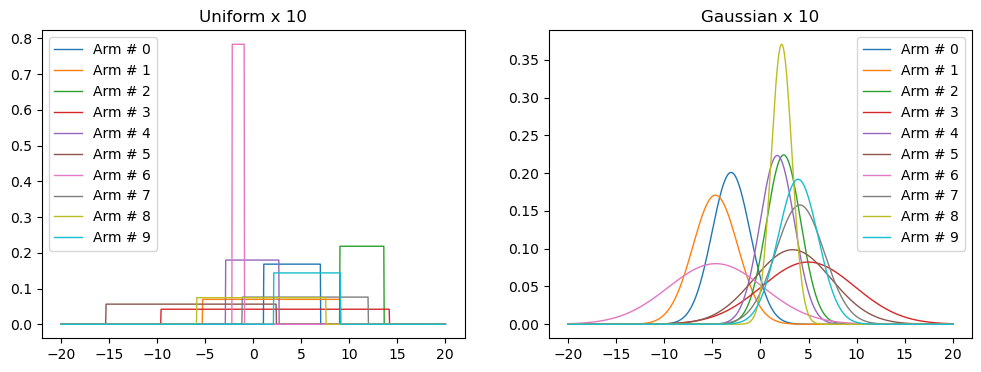

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

xs = np.linspace(-20, 20, 1000)

for i in range(2):
    mab, mab_desc = test_mabs[i + 1]
    for j in range(10):
        axs[i].plot(xs, mab._arms[j].pdf(xs), label=f"Arm # {j}", linewidth=1)
    axs[i].legend()
    axs[i].set_title(mab_desc)

plt.show()

Посмотрим, какие из ручек у получившихся бандитов имеют наибольшую среднюю награду

In [22]:
for mab, mab_desc in test_mabs:
    a_opt, r_exp = mab.optimal_action_reward
    print(mab_desc)
    print(f"    optimal arm: {a_opt}, expected_reward: {r_exp:.2f}")
    print()

Bernoulli(ps=[0.55 x 1, 0.45 x 9])
    optimal arm: 0, expected_reward: 0.55

Uniform x 10
    optimal arm: 2, expected_reward: 11.31

Gaussian x 10
    optimal arm: 3, expected_reward: 4.97



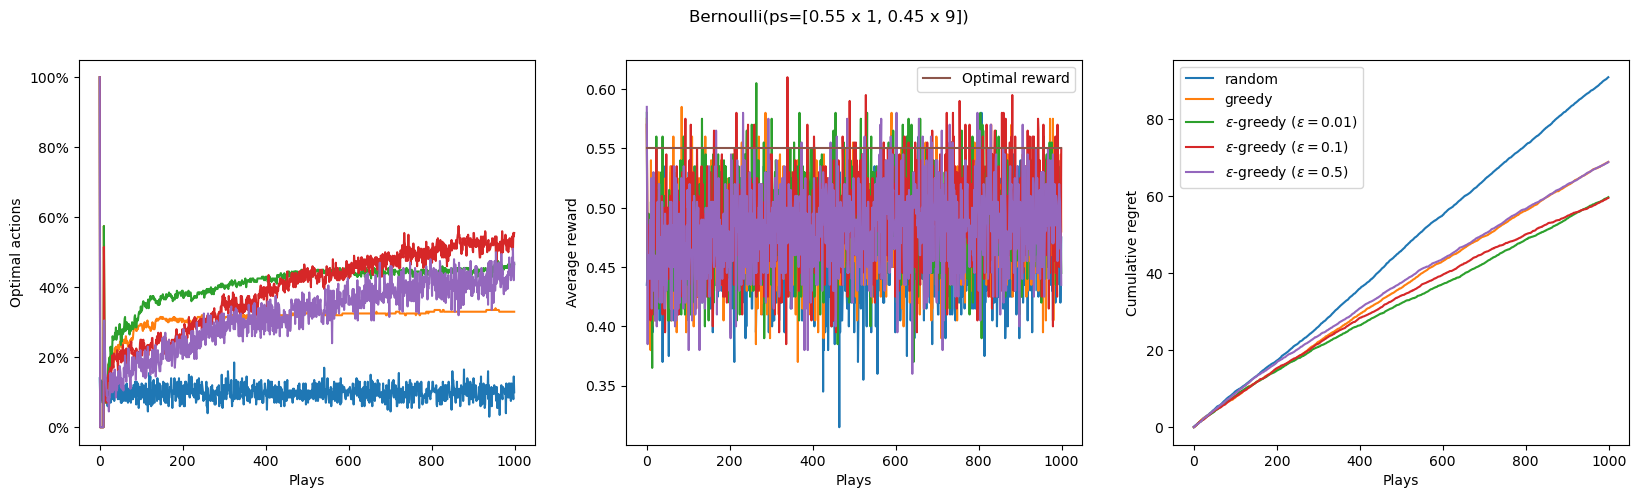

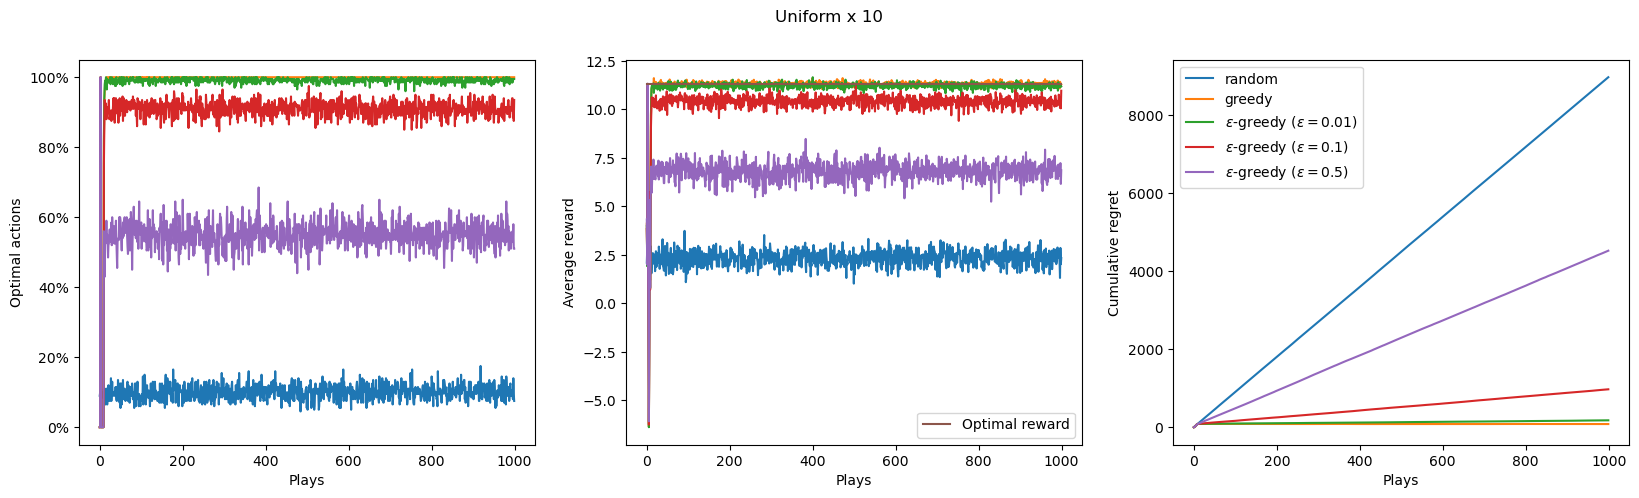

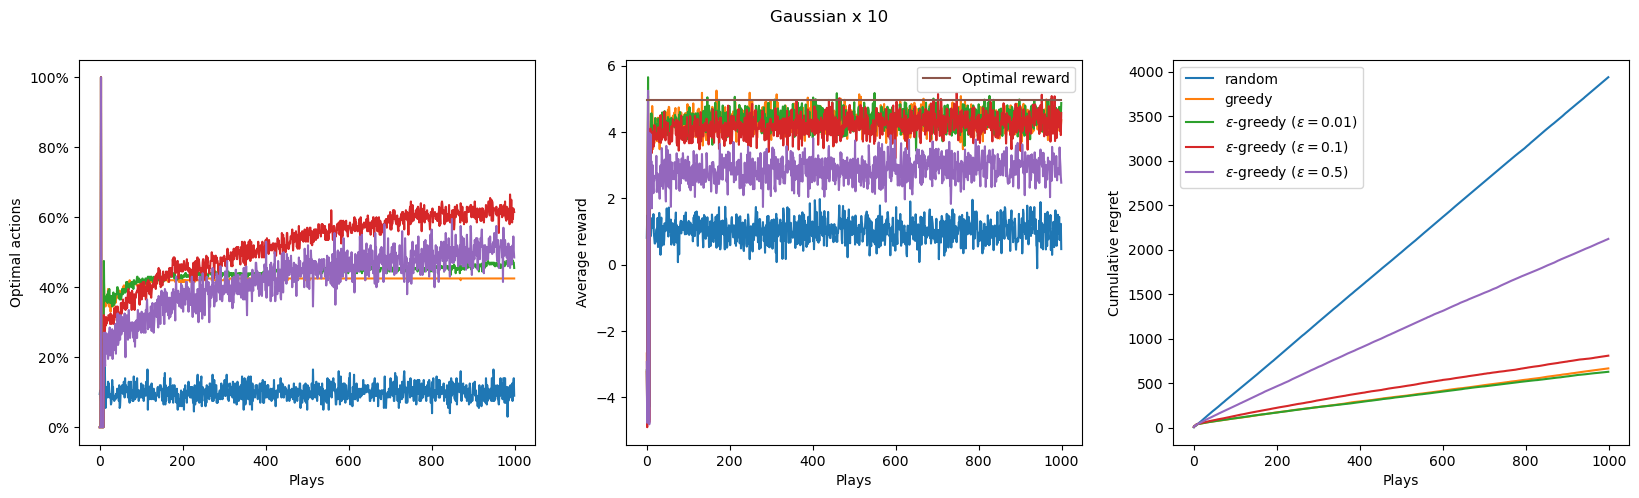

In [23]:
bench_kwargs = {
    "n_rounds": 1000,
    "n_runs": 200,
    "threads": 10,
}

agents = [
    Random(10),
    Greedy(10),
    EpsilonGreedy(10, 0.01),
    EpsilonGreedy(10, 0.1),
    EpsilonGreedy(10, 0.5),
]

labels = [
    "random",
    "greedy",
    r"$\varepsilon$-greedy ($\varepsilon = 0.01$)",
    r"$\varepsilon$-greedy ($\varepsilon = 0.1$)",
    r"$\varepsilon$-greedy ($\varepsilon = 0.5$)",
]

for mab, title in test_mabs:
    fig, axs = plot_performance_results([get_average_performance(mab, ag, **bench_kwargs) for ag in agents], labels)
    fig.suptitle(title)
    plt.show()

**Выводы:**

1. Очевидно, случайная стратегия никак не учитывает знания о получаемых наградах, поэтому она выбирает правильную ручку с вероятностью $\frac{1}{M}$. Её средняя награда есть среднее ожидаемых наград всех ручек, а цена обучения (regret) линейна по числу раундов. В дальнейшем не будем её рассматривать.
2. Выбор $\varepsilon$ для $\varepsilon$-жадных стратегий влияет на их результативность. В целом, чем больше $\varepsilon$, тем ближе стратегия к случайной, но на конечном промежутке времени наиболее удачное $\varepsilon$ зависит от конкретного многорукого бандита.

### $\varepsilon_n$-жадные стратегии

Серьёзный, но устранимый недостаток $\varepsilon$-жадных стратегий заключается в том, что они по определению будут выбирать неоптимальную ручку с вероятностью $\frac{M - 1}{M}\varepsilon$ вне зависимости от накопленного опыта, а потому их цена обучения (regret) будет линейна по числу раундов. Одним из возможных решений этой проблемы являются $\varepsilon_n$-жадные стратегии, т.е. это те же $\varepsilon$-жадные стратегии, но $\varepsilon$ уменьшается со временем (разумно сделать $\varepsilon_n \to 0$).

Возникает вопрос, как быстро должно убывать $\varepsilon_n$? Легко видеть, что ожидаемое число "исследовательских" действий равно $$\sum_{n = 1}^{\infty} \varepsilon_n$$
Если эта сумма конечна, то оценки ожидаемых выигрышей не будут сходиться к истинным значениям.

С другой стороны, хотелось бы, чтобы доля субоптимальных действий стремилась к нулю (иначе regret всё ещё будет линейным):
$$\frac1n \sum_{n = 1}^{\infty} \varepsilon_n \to 0$$

С первого взгляда, кажется разумным выбрать $\varepsilon_n \propto \frac1n$.

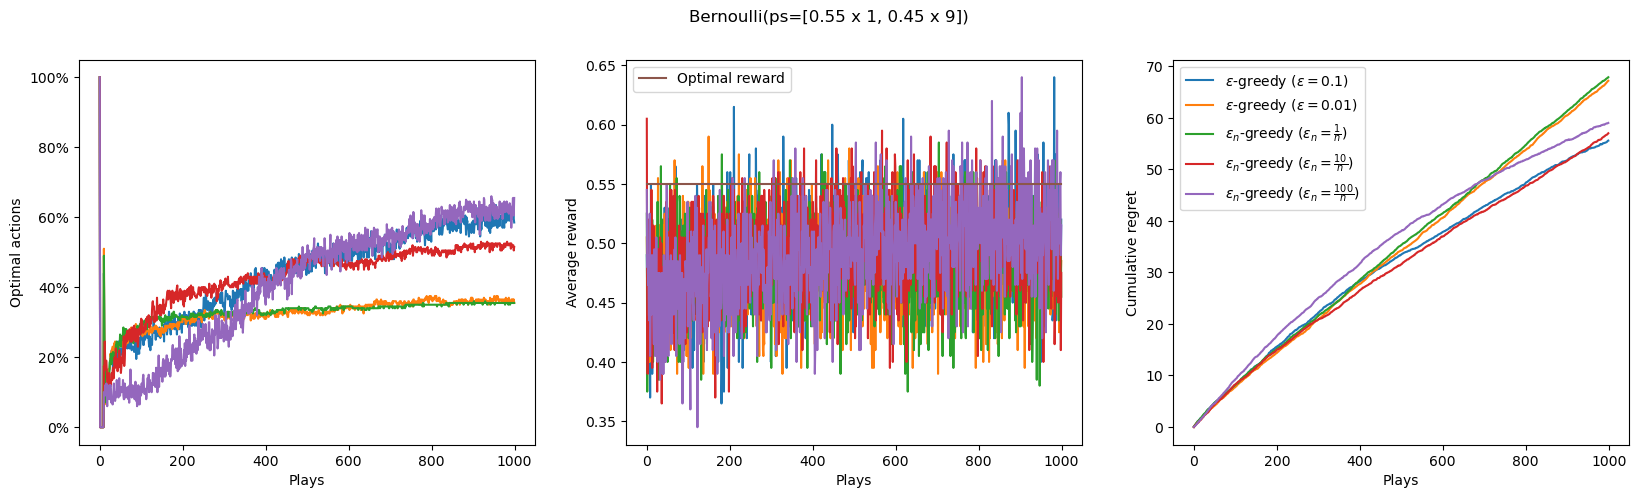

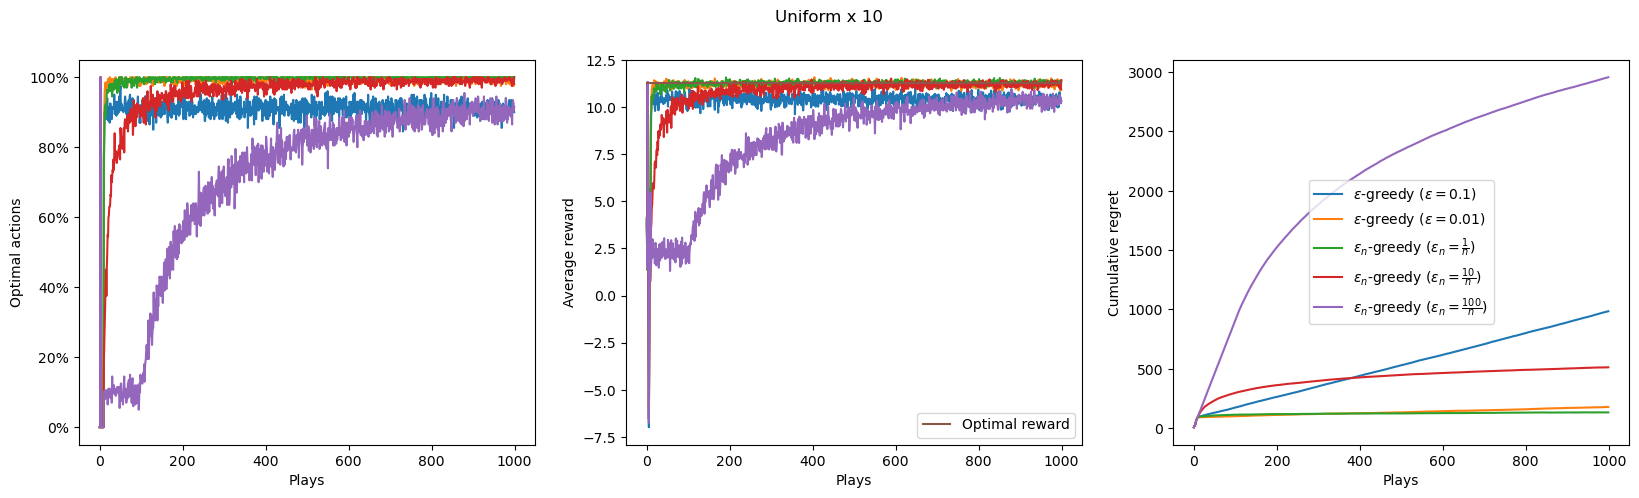

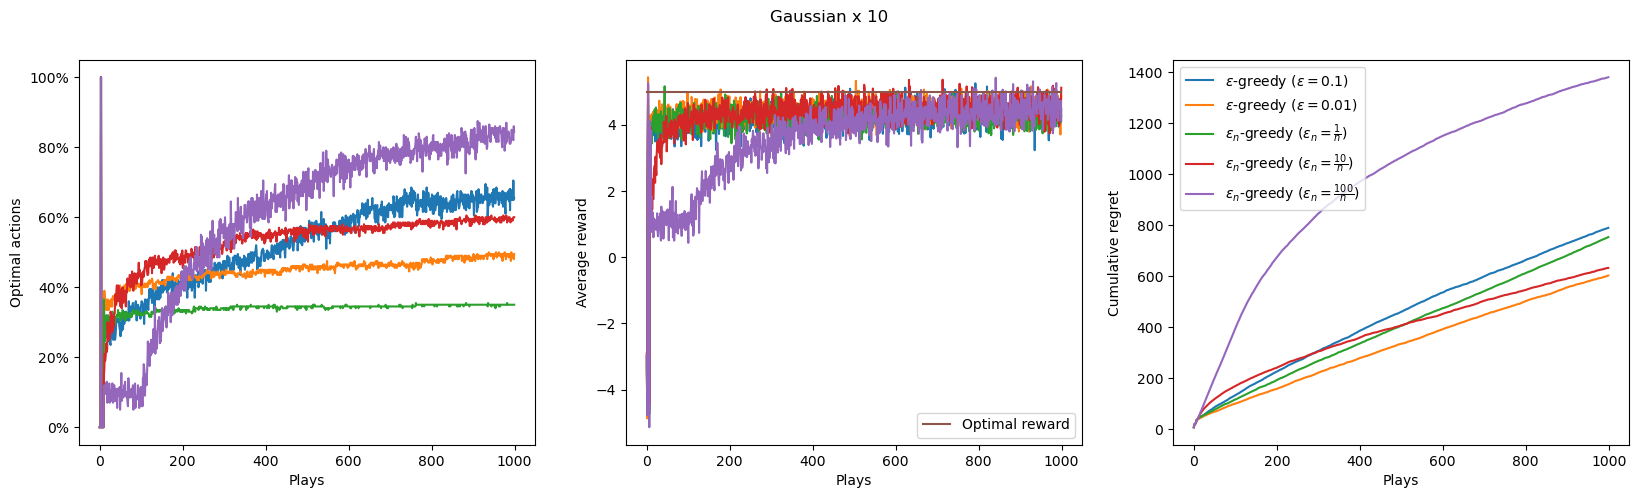

In [24]:
bench_kwargs = {
    "n_rounds": 1000,
    "n_runs": 200,
    "threads": 10,
}

def f1n(n):
    return 1/n

def f10n(n):
    return 10/n

def f100n(n):
    return 100/n

agents = [
    EpsilonGreedy(10, 0.1),
    EpsilonGreedy(10, 0.01),
    EpsilonGreedy(10, f1n),
    EpsilonGreedy(10, f10n),
    EpsilonGreedy(10, f100n),
]

labels = [
    r"$\varepsilon$-greedy ($\varepsilon = 0.1$)",
    r"$\varepsilon$-greedy ($\varepsilon = 0.01$)",
    r"$\varepsilon_n$-greedy ($\varepsilon_n = \frac{1}{n}$)",
    r"$\varepsilon_n$-greedy ($\varepsilon_n = \frac{10}{n}$)",
    r"$\varepsilon_n$-greedy ($\varepsilon_n = \frac{100}{n}$)",
]

for mab, title in test_mabs:
    fig, axs = plot_performance_results([get_average_performance(mab, ag, **bench_kwargs) for ag in agents], labels)
    fig.suptitle(title)
    plt.show()

**Выводы:**

1. Как и в случае с $\varepsilon$-жадными стратегиями, результативность $\varepsilon_n$-жадных стратегий на конечном интервале времени зависит от выбора $\varepsilon_n$. Даже если ограничиться $\varepsilon_n \propto \frac1n$, то выбор коэффициента пропорциональность всё ещё играет роль.
2. Судя по экспериментам можно предположить, что **чем труднее отличить ручки бандитов, тем больше нужно делать исследований**, т.е. тем лучше себя показывают ($\varepsilon$-) и $\varepsilon_n$-жадные стратегии с бóльшими $\varepsilon$ и $\varepsilon_n$ соответственно. Не формально, под «трудностью в различии» ручек бандитов имеется ввиду разность между ожиданием выигрыша оптимальной и субоптимальных ручек по отношению к дисперсии распределений наград.
3. $\varepsilon$-Жадные стратегии, уделяющие много времени исследованиям на ранних этапах, теряют значительную часть суммарной награды, дёргая за ручки с низкими ожидаемыми наградами. Поскольку исследовние делается равномерно, то на каждом из шагов вероятность дёрнуть за топ-2 ручку (с точки зрения текущих оценок) такая же, как и для топ-$M$ ручки — $\frac{\varepsilon}{M}$.

Таким образом, нужна стратегия, которая будет делать исследования не равномерно, а в соответствии с текущими оценками ожидаемых наград. Возможным решением могут быть, так называемые, UCB-стратегии, опирающиеся на upper confidence bound (UCB).

## UCB

Стратегия UCB-1 на каждом шаге дёргает ручку с наибольшим *приоритетом:*
$$Priority(a) = \hat{q}(a) + c\sqrt{\frac{\ln t}{N_t(a)}}$$
где
- $\hat{q}(a)$ — текущая оценка ожидаемой награды действия $a$;
- $t$ — номер шага (время);
- $N_t(a)$ — сколько раз действие $a$ было совершено к моменту $t$;
- $c$ — параметр стратегии, определяющий «соотношение между exploration и exploitation». Чем больше $c$, тем чаще стратегия будет делать исследования.

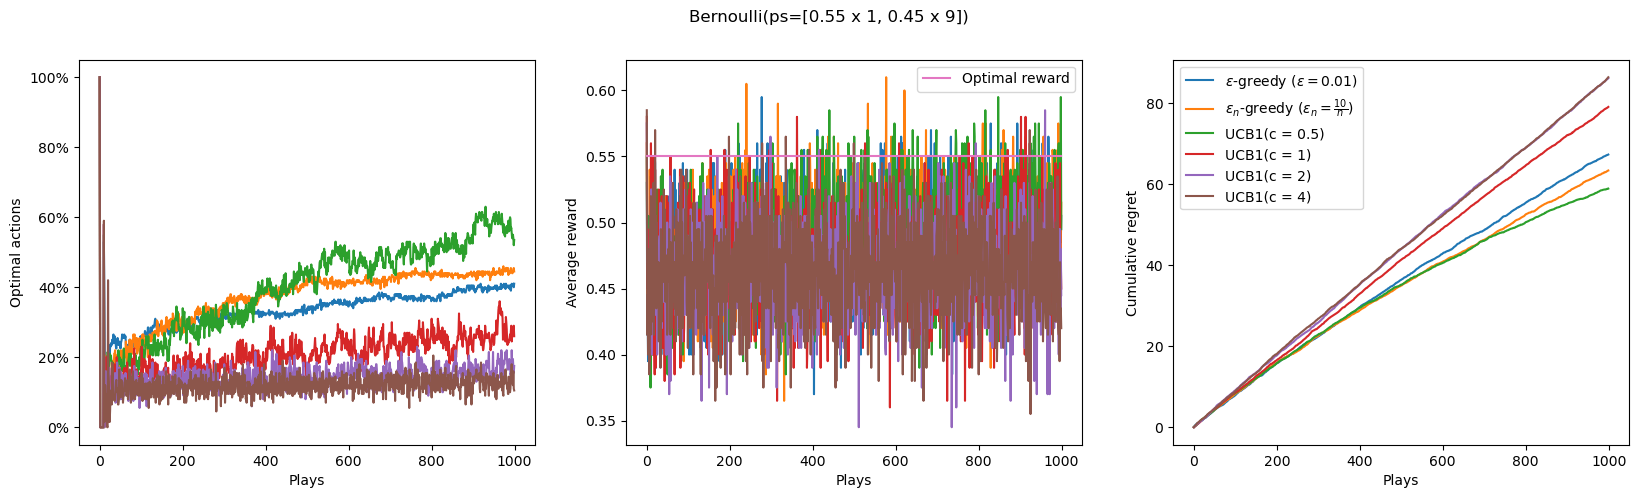

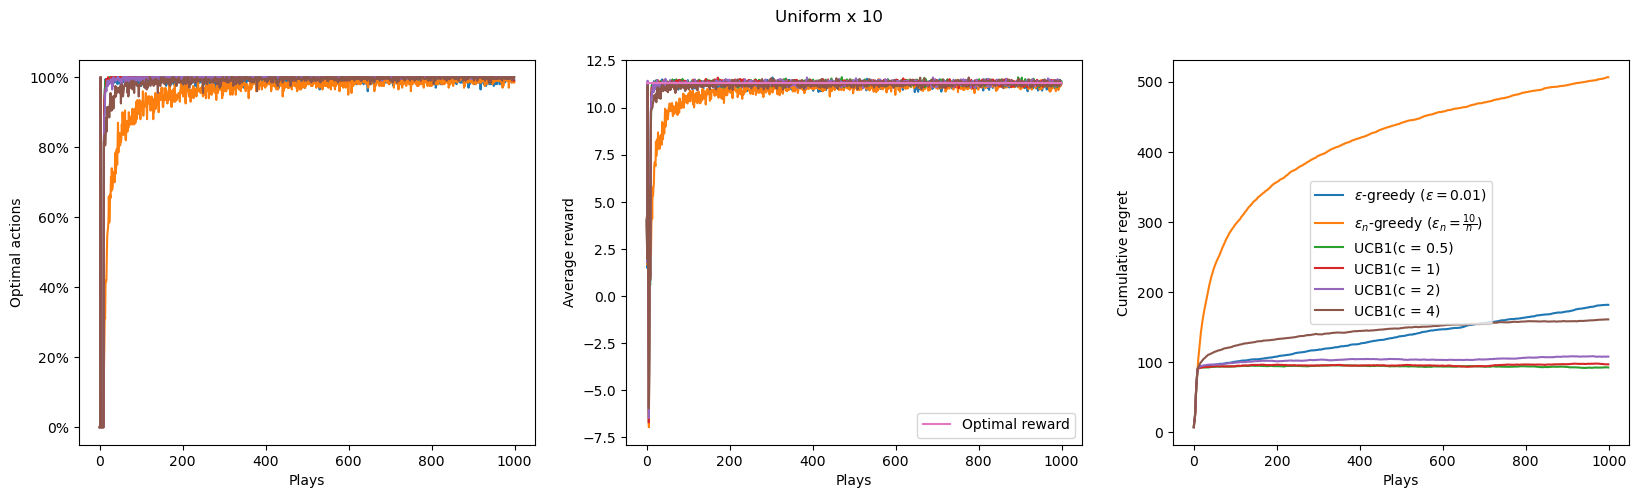

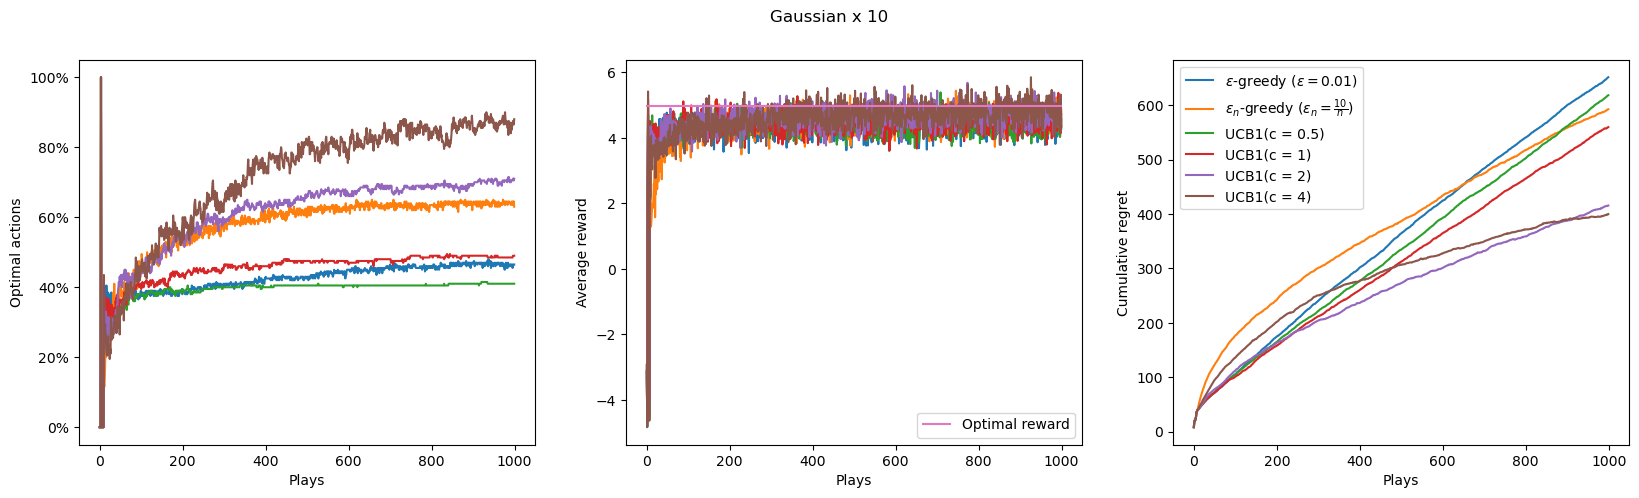

In [25]:
from bandits.agent import UCB1


bench_kwargs = {
    "n_rounds": 1000,
    "n_runs": 200,
    "threads": 10,
}

def f10n(n):
    return 10/n

agents = [
    EpsilonGreedy(10, 0.01),
    EpsilonGreedy(10, f10n),
    UCB1(10, 0.5),
    UCB1(10, 1.0),
    UCB1(10, 2.0),
    UCB1(10, 4.0),
]

labels = [
    r"$\varepsilon$-greedy ($\varepsilon = 0.01$)",
    r"$\varepsilon_n$-greedy ($\varepsilon_n = \frac{10}{n}$)",
    "UCB1 (c = 0.5)",
    "UCB1 (c = 1)",
    "UCB1 (c = 2)",
    "UCB1 (c = 4)",
]

for mab, title in test_mabs:
    fig, axs = plot_performance_results([get_average_performance(mab, ag, **bench_kwargs) for ag in agents], labels)
    fig.suptitle(title)
    plt.show()

**Выводы**

1. Видно, что UCB-1 получает серьёзное преимущество во втором испытании. Это достигается за счёт того, что UCB-1 практически не тратит свое время на действия с очень низкими оценками наград.
2. Любопытно, что UCB-1 при $c = 0.5$ показывается себя абсолютно противоположным образом в первом и третьем испытаниях. Для гауссовского бандита доля выбора оптимальной ручки практически замирает на отметке 40%, что хуже даже 0.01-жадной стратегии.

Если во втором испытании преимущество UCB-1 явно заметно, то с первым и третьим не всё так очевидно. Посмотрим на эффективность стратегий на более длином интервале времени

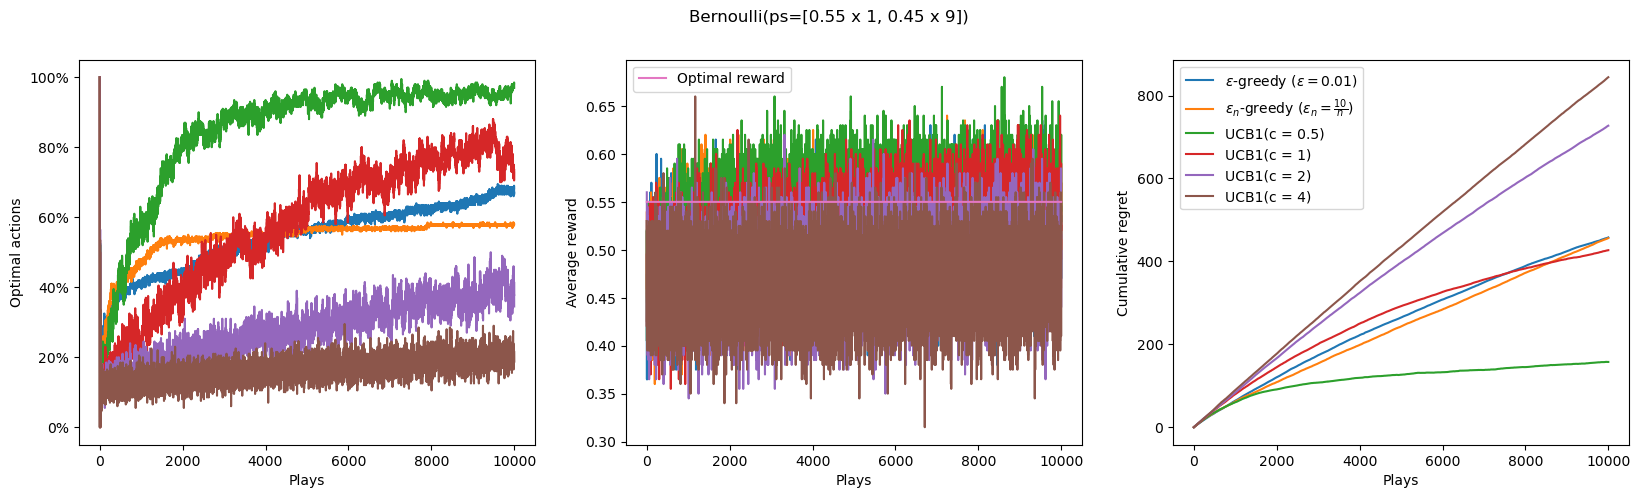

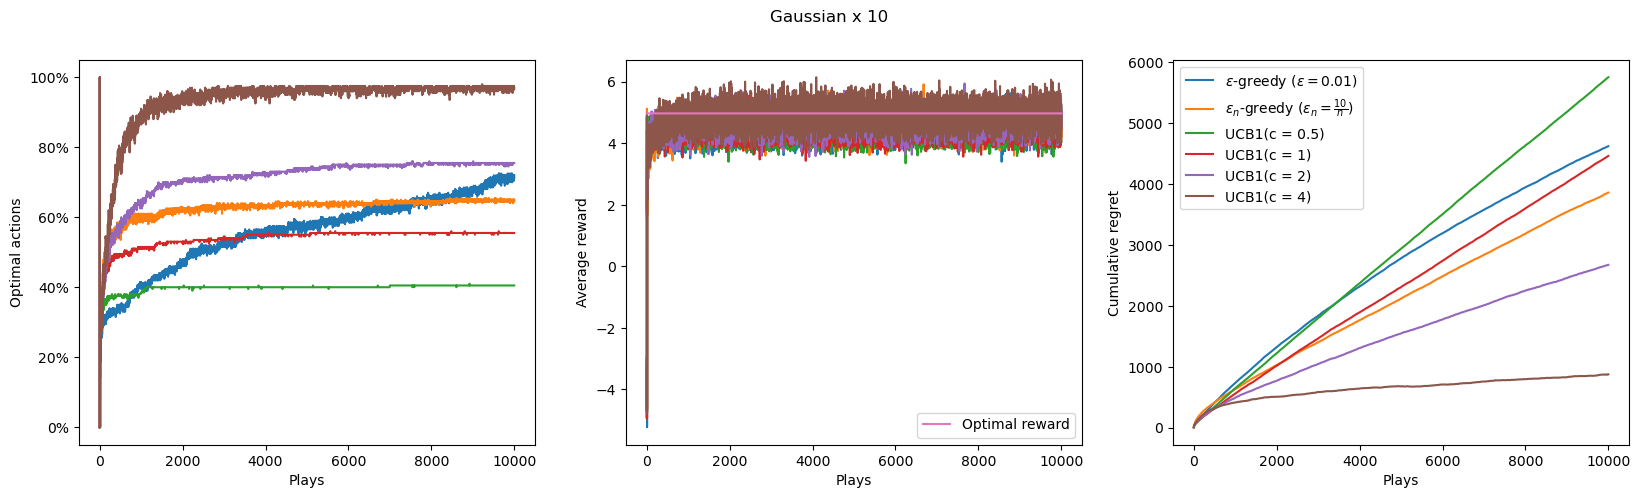

In [26]:
bench_kwargs = {
    "n_rounds": 10000,
    "n_runs": 200,
    "threads": 10,
}

def f10n(n):
    return 10/n

agents = [
    EpsilonGreedy(10, 0.01),
    EpsilonGreedy(10, f10n),
    UCB1(10, 0.5),
    UCB1(10, 1.0),
    UCB1(10, 2.0),
    UCB1(10, 4.0),
]

labels = [
    r"$\varepsilon$-greedy ($\varepsilon = 0.01$)",
    r"$\varepsilon_n$-greedy ($\varepsilon_n = \frac{10}{n}$)",
    "UCB1(c = 0.5)",
    "UCB1(c = 1)",
    "UCB1(c = 2)",
    "UCB1(c = 4)",
]

for mab, title in [test_mabs[0], test_mabs[2]]:
    fig, axs = plot_performance_results([get_average_performance(mab, ag, **bench_kwargs) for ag in agents], labels)
    fig.suptitle(title)
    plt.show()

**Выводы:**

1. К сожалению, также как и $\varepsilon$-жадные стратегии, UCB-1 не лишена гиперпараметра ($с$), который сильно влияет на результативность стратегии.

# Work in progress...

Сравнение стратегий с помощью parameter study (см. Figure 2.6 в Sutton, Barto)

### Теорема о UCB1

### Thompson sampling

## Нестационарные бандиты

схема обновления оценок

## Более сложные бандиты

- Экспоненциальные. Коши

Сравнение для бандитов с одинаковыми ожиданием и дисперсией, но разными распределениями
- ожидание у всех по нулю
- ожидание у всех 1

Adversarial-bandits, которые меняют свои выигрыши в соответствии с действиями игрока